<a href="https://colab.research.google.com/github/VaishnaviJambhale/Billing-software/blob/main/Copy_of_EFFICIENTNETB3_97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB6,InceptionResNetV2#,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
#import tensorflow as tf
#tf.__version__

In [3]:
#!pip uninstall tensorflow

In [4]:
#!pip install --downgrade tensorflow

In [5]:
import tensorflow as tf
tf.__version__

'2.9.1'

In [6]:
#!pip uninstall tensorflow -y
#!pip install  tensorflow==2.9.1

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#create labels
classes=[]
filename='/content/drive/MyDrive/Brain Tumor/Brain Tumor Dataset - 4 Classes/Dataset - 4 classes'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)

['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor']


In [9]:
#resize images and put together Training and Testing folder

X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): #Instantly make your loops show a smart progress meter 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)    

100%|██████████| 105/105 [00:00<00:00, 286.49it/s]


In [10]:
import imutils

In [11]:
IMG_SIZE = (160,160)
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        crop_img = cv2.resize(new_img, (IMG_SIZE))
        set_new.append(crop_img)

    return np.array(set_new)

In [12]:
def plot_samples(X, y, classes, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(classes)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(classes[index]))
        plt.show()

In [13]:
!pip install imutils

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
img = cv2.imread('/content/drive/MyDrive/Brain Tumor/Brain Tumor Dataset - 4 Classes/Dataset - 4 classes/Training/meningioma_tumor/m (103).jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

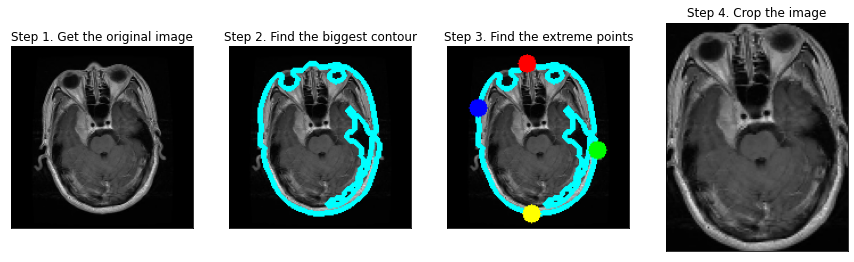

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [16]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
#X_test_crop = crop_imgs(set_name=X_test)

In [17]:
def save_new_images(x_set, y_set, folder_name):
    i = 1
    for (img, imclass) in zip(x_set, y_set):
        if imclass == "glioma_tumor":
            cv2.imwrite(folder_name+'glioma_tumor/'+'gg'+'('+str(i)+')'+'.jpg', img)
            i += 1
        elif imclass == "meningioma_tumor":
            cv2.imwrite(folder_name+'meningioma_tumor/'+'m'+'('+str(i)+')'+'.jpg', img)
            i += 1
        elif imclass == "no_tumor":
            cv2.imwrite(folder_name+'no_tumor/'+'image'+'('+str(i)+')'+'.jpg', img)   
            i += 1 
        else:
            cv2.imwrite(folder_name+'pituitary_tumor/'+'p'+'('+str(i)+')'+'.jpg', img)
            i += 1

In [18]:
# saving new images to the folder
!mkdir TRAIN_CROP  TRAIN_CROP/glioma_tumor TRAIN_CROP/meningioma_tumor TRAIN_CROP/pituitary_tumor  TRAIN_CROP/no_tumor 

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
#save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
#save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/glioma_tumor’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/meningioma_tumor’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/pituitary_tumor’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/no_tumor’: File exists


In [19]:
#data augmentation
#from tensorflow.keras.applications.efficientnet import preprocess_input

RANDOM_SEED = 123

TRAIN_DIR = 'TRAIN_CROP/'

#X_train, y_train = shuffle(X_train_crop,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)


train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

datagen.fit(X_train_crop)
X_train_crop.shape
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train_crop,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

Found 3264 images belonging to 4 classes.


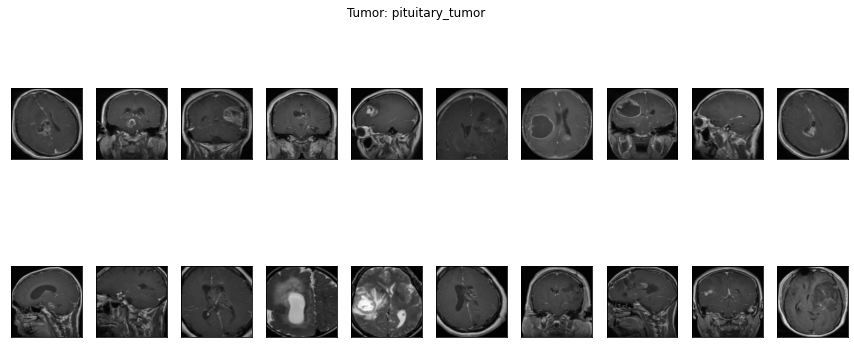

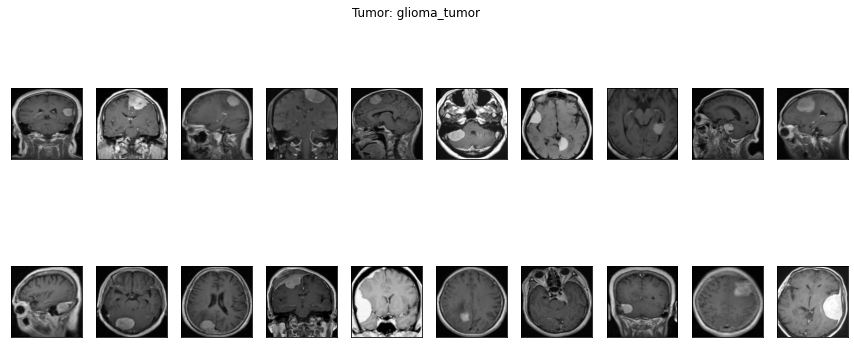

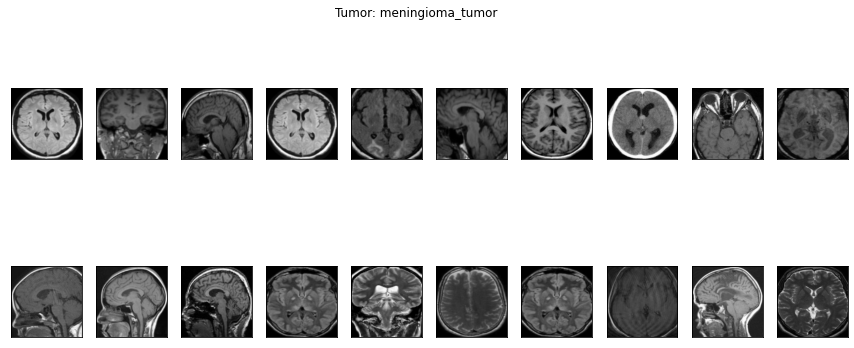

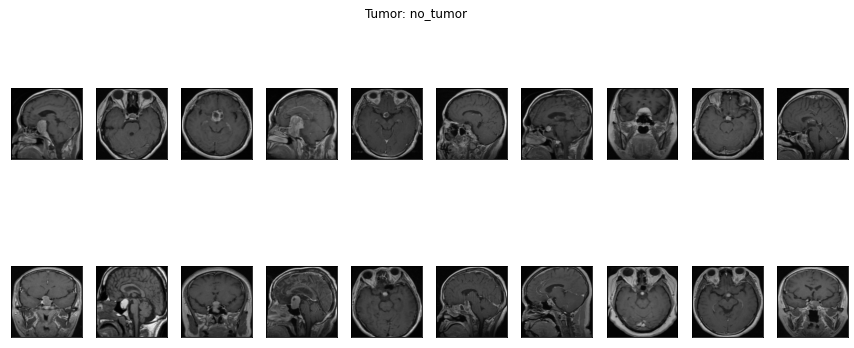

In [20]:
plot_samples(X_train, y_train, classes, 20)

In [21]:
print(y_train)

#load EfficientNet
EfficientNet=EfficientNetB3(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

[3 1 1 ... 3 3 0]


In [22]:
#train the model
import tensorflow as tf
#from tensorflow.keras.layers import Rescaling

tf.random.set_seed(45)

model = EfficientNet.output
#model = tf.keras.layers.Rescaling(scale=1./255, offset=0.0, dtype='float32')(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.55)(model)
model = tf.keras.layers.Dense(60,activation='relu',kernel_initializer='GlorotNormal')(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
    epsilon=1e-08)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)
'''tf.convert_to_tensor(X_train)
tf.convert_to_tensor(y_train)'''
'''X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)'''

history=model.fit(X_train, y_train ,validation_data = (X_test,y_test),epochs=1, batch_size=13,callbacks=early_stopping_cb)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 160, 160, 3)  0           ['normalization[0][0]']      

In [23]:
y_train.shape,y_test.shape

((2774,), (490,))

16/16 [==============================] - 2s 101ms/step - loss: 1.3914 - accuracy: 0.2939
Accuracy: 29.387754


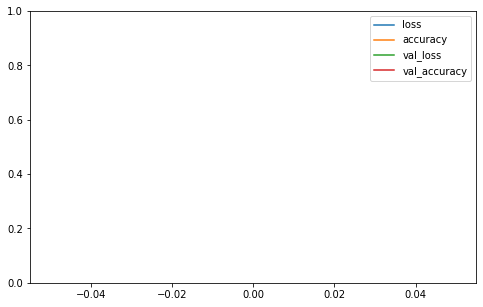

In [24]:
# change directory
#os.chdir(r'../input/brain-tumor-classification-mri')
#print(os.getcwd())

#save the model
#model.save('/kaggle/working/EfficientNetB3.h5')
#model.save_weights('/kaggle/working/EfficientNetB3_weights.h5')

#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
#plt.grid(True)

#plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
plt.savefig('/content/drive/MyDrive/Brain Tumor/EfficientNetB3.png')
loss, accuracy = model.evaluate(X_test,y_test)

#print accuracy    
print('Accuracy: %f' % (accuracy*100))

In [25]:
#load the model
#model=keras.models.load_model('/kaggle/working/EfficientNetB3.h5')  

#model.summary()
loss, accuracy = model.evaluate(X_test,y_test)

16/16 [==============================] - 1s 60ms/step - loss: 1.3914 - accuracy: 0.2939


In [26]:
#info about optimizers
model.optimizer.get_config()  

{'name': 'Adam',
 'learning_rate': 1.6e-05,
 'decay': 0.0,
 'beta_1': 0.91,
 'beta_2': 0.9994,
 'epsilon': 1e-08,
 'amsgrad': False}

In [27]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 29.388 
 loss : 1.391


In [28]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

16/16 [==============================] - 3s 64ms/step


In [29]:
pd.Series(pred_labels).value_counts()

meningioma_tumor    238
no_tumor            221
glioma_tumor         18
pituitary_tumor      13
dtype: int64

Text(70.8, 0.5, 'Predicted class')

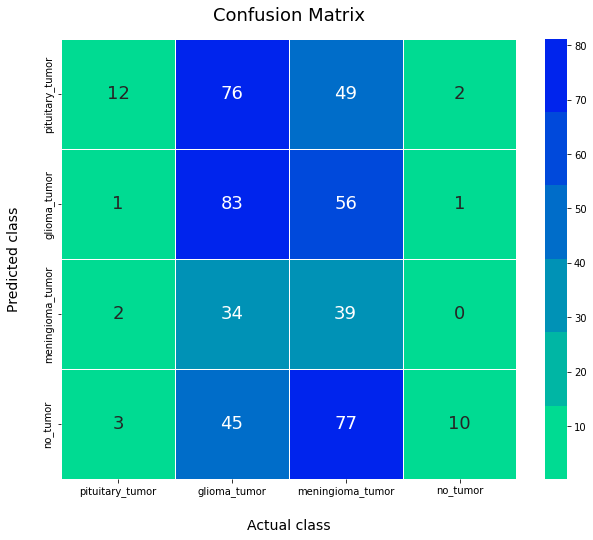

In [30]:
# Confusion Matrix

cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
 #annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

In [31]:
#Model Performance Score
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

 pituitary_tumor       0.67      0.09      0.15       139
    glioma_tumor       0.35      0.59      0.44       141
meningioma_tumor       0.18      0.52      0.26        75
        no_tumor       0.77      0.07      0.14       135

        accuracy                           0.29       490
       macro avg       0.49      0.32      0.25       490
    weighted avg       0.53      0.29      0.25       490



In [32]:
import matplotlib.image as mpimg
os.chdir('/content/drive/MyDrive/Brain Tumor/Brain Tumor Dataset - 4 Classes/Dataset - 4 classes')
TEST_DIR='Testing'
#fetch images from the original validation dataset and resize them in order to plot the images.
images=[] 
n_classes=4
z_max=20
for i,filenames in enumerate(os.listdir(TEST_DIR)): 
    dir_fold=os.path.join(TEST_DIR, filenames)
    print(dir_fold)
    class_images=[]
    z=0
    for filename in os.listdir(dir_fold):
        if z < z_max:
            img_path = os.path.join(dir_fold, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img,(image_size,image_size))
            class_images.append(img)
            z+=1
        else:
            break
    images.append(class_images)
images=images[:20]

Testing/pituitary_tumor
Testing/no_tumor
Testing/glioma_tumor
Testing/meningioma_tumor


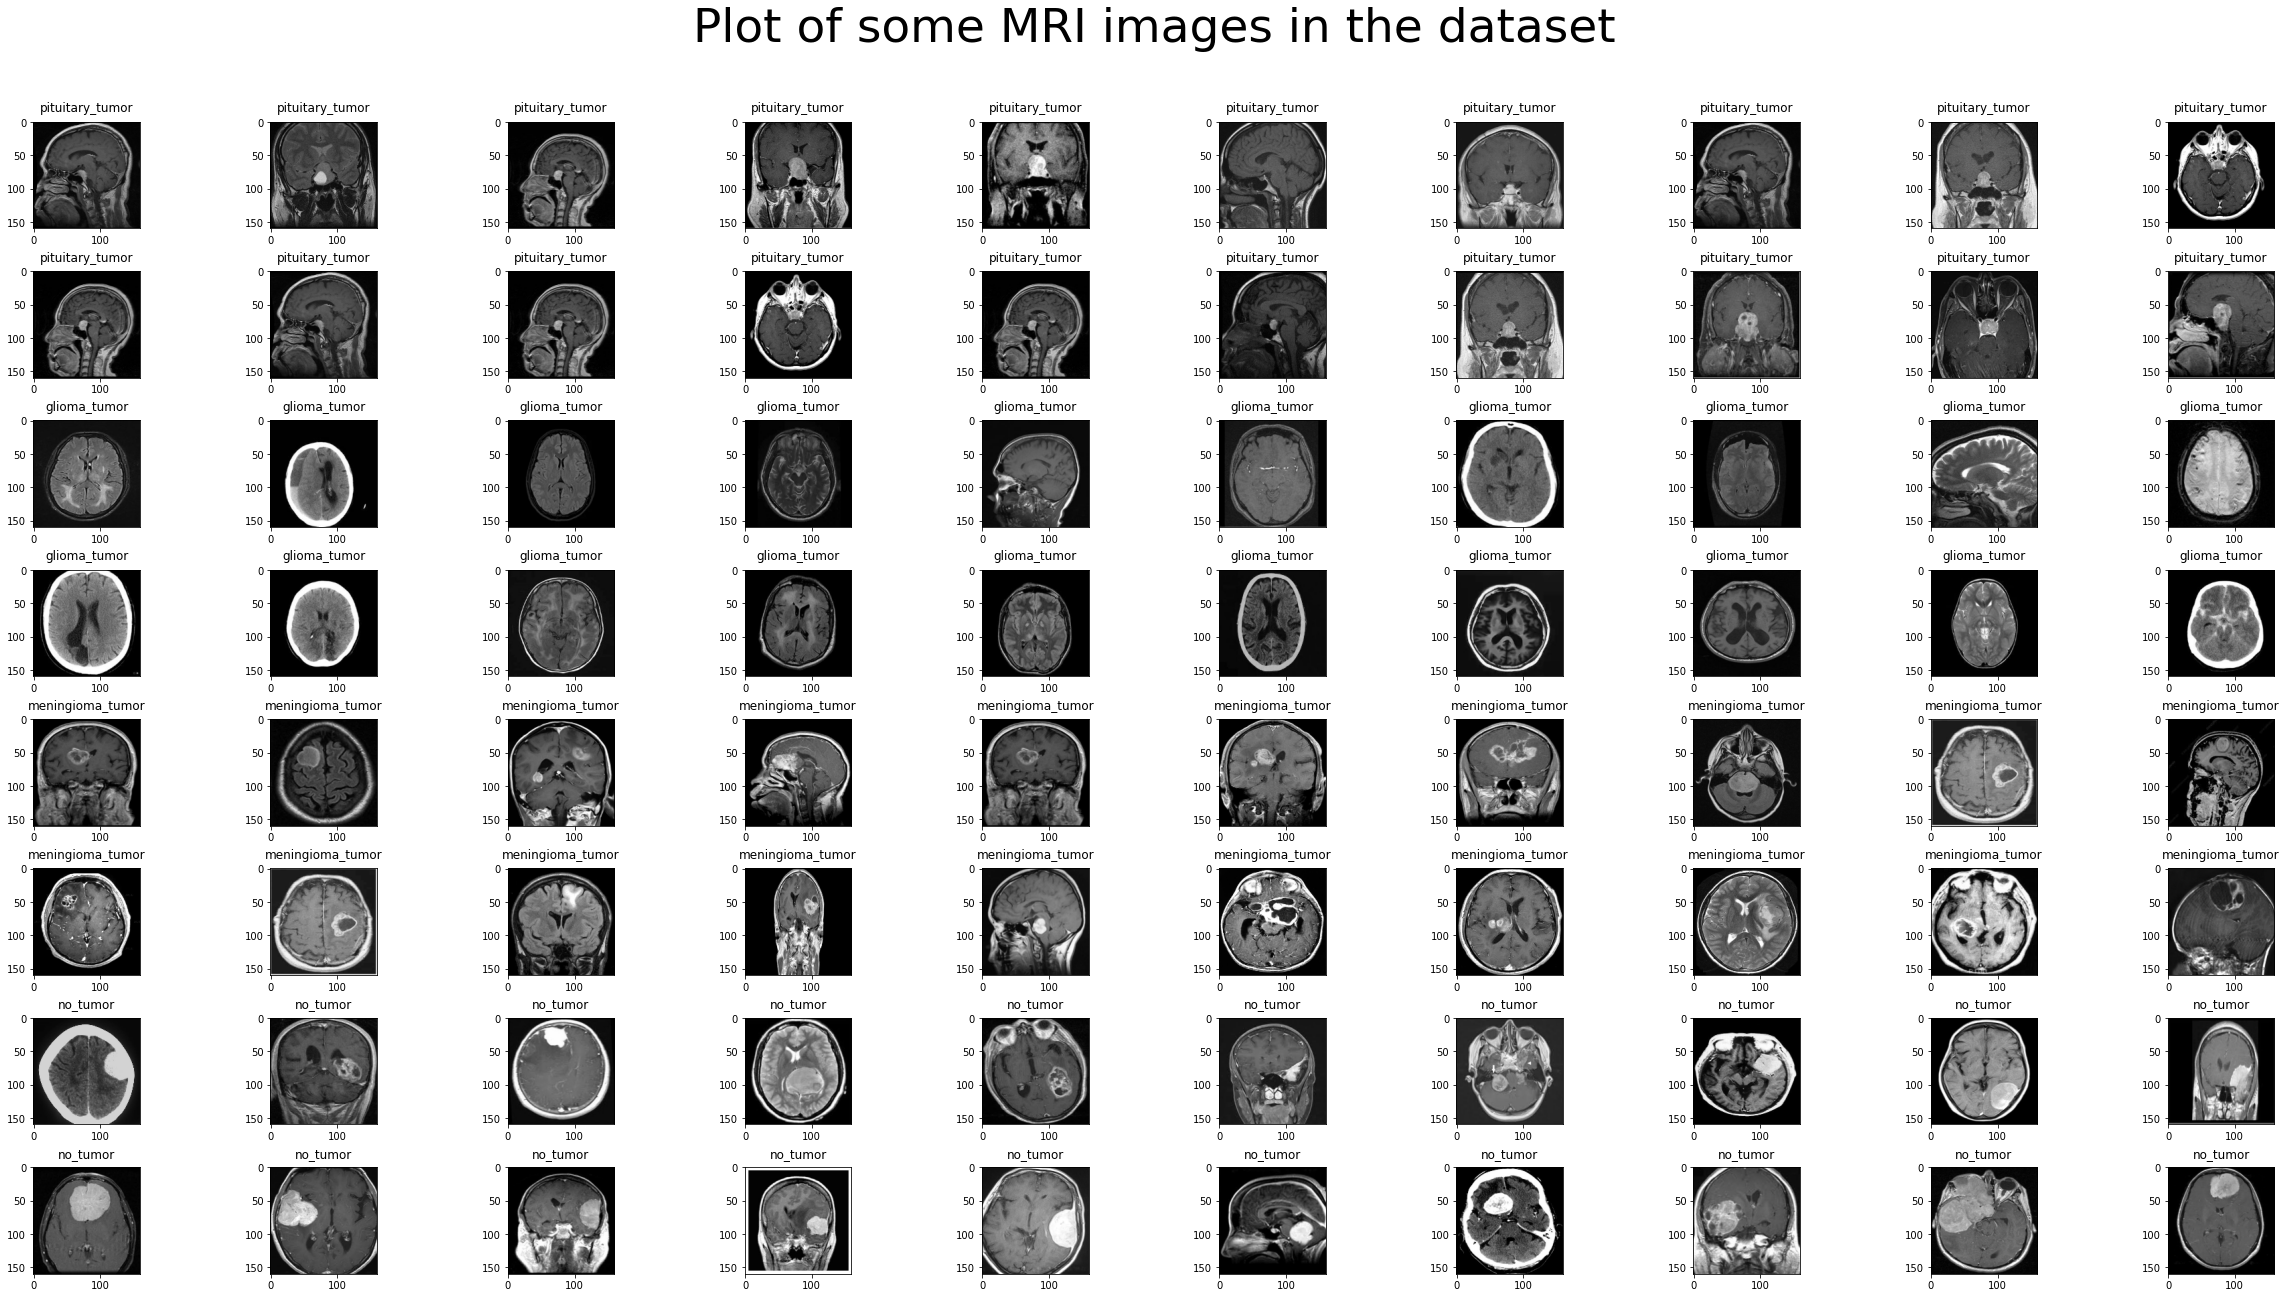

In [33]:
#here I plotted the images based on columns and z_max (defined by the user, 
#but it should be a multiple of the # of columns)
columns = 10
fig,axes=plt.subplots(int(len(images)*len(images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    #print(images_class)
    fig.suptitle('Plot of some MRI images in the dataset',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)

In [34]:
X_test_images=dict(zip(classes,[[],[],[],[]]))
for y,ele in enumerate(pred):
    for i,x in enumerate(X_test_images):
        #num=pred[ind]
        if ele==i:
            if len(X_test_images[classes[i]])<z_max:
                X_test_images[classes[i]].append(X_test[y])
X_test_images=[X_test_images[i]  for i in X_test_images]

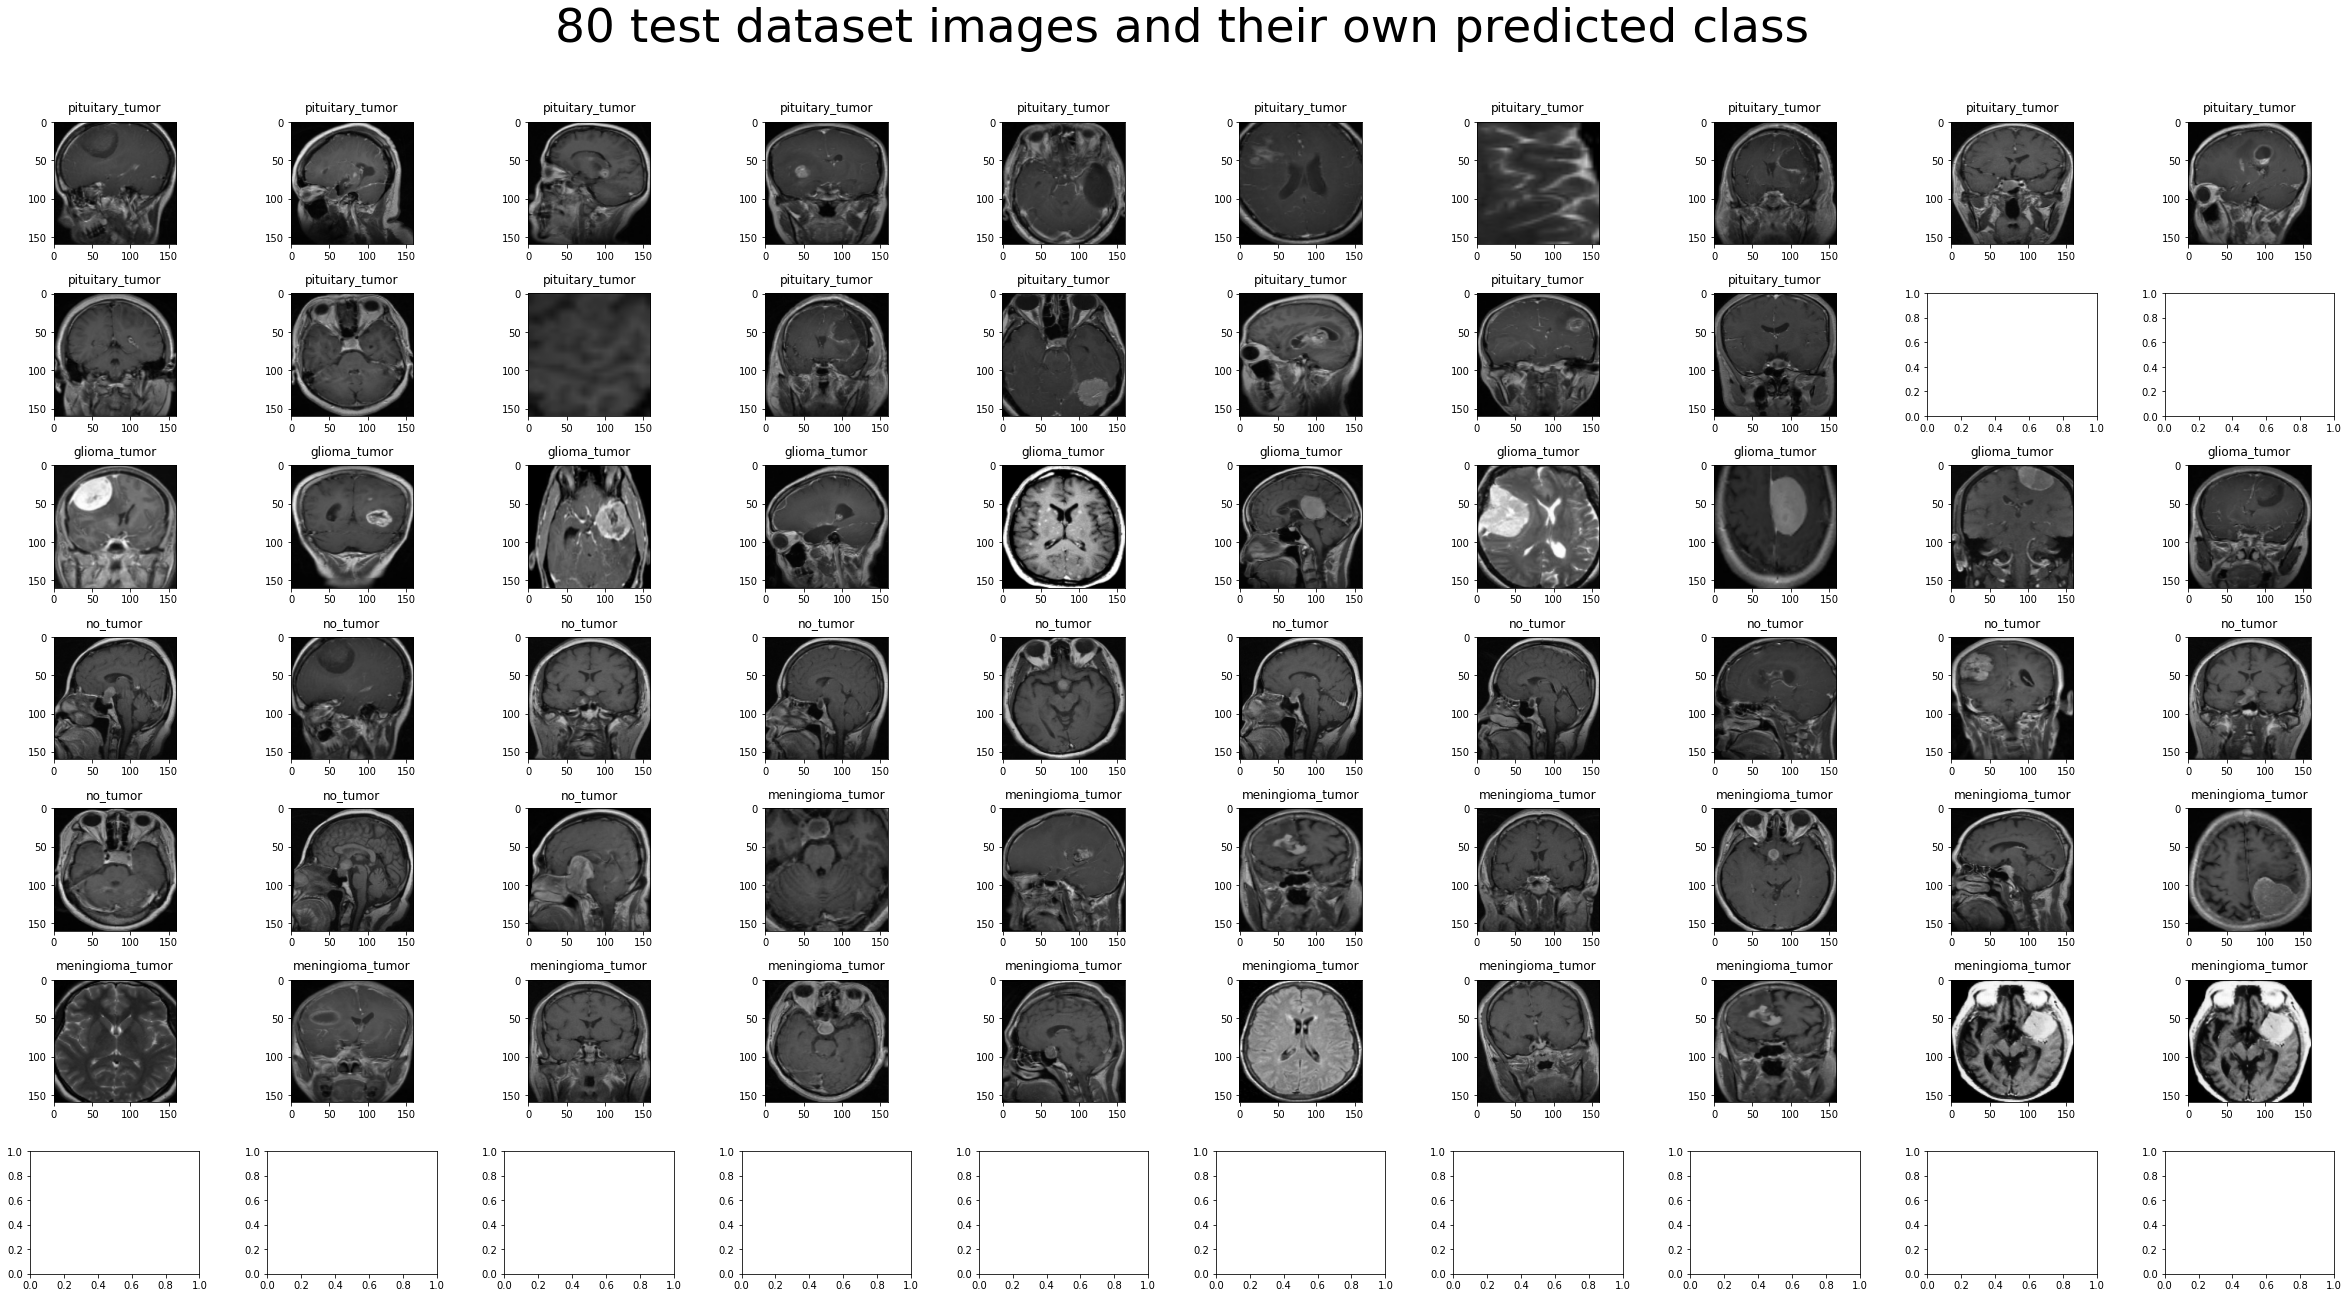

In [35]:
columns = 10
fig,axes=plt.subplots(int(len(X_test_images)*len(X_test_images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(X_test_images):
    #print(images_class)
    fig.suptitle('80 test dataset images and their own predicted class',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        if int((i)*(len(ind)/columns)+(int(j/columns)))<n_classes*(z_max/columns):
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)

In [36]:
X_test.shape

(490, 160, 160, 3)

In [37]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model.h5")
print("Saved model to disk")    

Saved model to disk


In [38]:
%pwd

'/content/drive/MyDrive/Brain Tumor/Brain Tumor Dataset - 4 Classes/Dataset - 4 classes'

In [41]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [42]:
# evaluate loaded model on test data
loaded_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 29.39%


In [43]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

# save the model to disk
filename = '29_accuracy_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [45]:
loaded_model = pickle.load(open(filename, 'rb'))
# evaluate loaded model on test data
loaded_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 29.39%


In [46]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [47]:
model = load_model('my_model.h5')

In [48]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 29.39%


In [39]:
from joblib import Parallel, delayed
import joblib

joblib.dump(model, 'filename_model.pkl')  

knn_from_joblib = joblib.load('filename_model.pkl')
  
# Use the loaded model to make predictions
knn_from_joblib.predict(X_test)

KeyboardInterrupt: ignored

In [ ]:
loaded_model = joblib.load(filename)

In [ ]:
#save the model
model.save(os.path.join('models/','EfficientNetB6.h5'))
model.save_weights(os.path.join('models/','EfficientNetB6_weights.h5'))

In [ ]:
#load EfficientNet
EfficientNet=EfficientNetB6(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
#train the model
tf.random.set_seed(79)
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
opt = Adam(
    learning_rate=0.000023,
    epsilon=1e-08,
    clipnorm=1.0)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=70, batch_size=8,callbacks=[early_stopping_cb])
